Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Results - MAE: 0.0109, RMSE: 0.0185, R²: 0.8704,mape:  0.014392, Accuracy: 98.56%


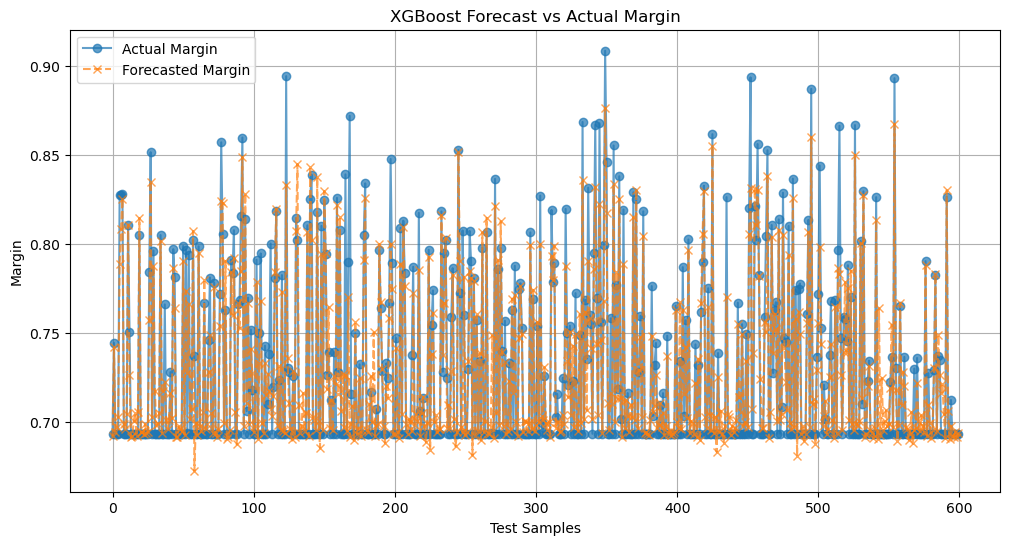

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Load and preprocess the dataset
file_path = "D:/pricing_model_data_with_margin_inventory_3000_ca_market.xlsx"
df = pd.read_excel(file_path)

# 2. Data Cleaning
def convert_price(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    elif pd.isna(x):
        return np.nan
    else:
        return float(x)

# Convert price columns to numeric
price_columns = ['Cost_Price', 'Competitor_Price', 'Price']
for col in price_columns:
    df[col] = df[col].apply(convert_price)

# Convert Margin to numeric
df['Margin'] = df['Margin'].apply(lambda x: float(x.rstrip('%')) / 100 if isinstance(x, str) else x)

# Convert other numeric columns
numeric_columns = ['Demand_Level', 'Market_Trend', 'Historical_Sales', 'Initial_Stock', 'Current_Stock']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Log Normalization
numeric_cols = ['Cost_Price', 'Demand_Level', 'Market_Trend', 'Historical_Sales',
                'Initial_Stock', 'Current_Stock', 'Price', 'Margin']

season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
df['Season_Number'] = df['Season'].map(season_mapping)

def log_normalize(x):
    return np.log1p(x - x.min() + 1)

data_normalized = df.copy()
for col in numeric_cols:
    data_normalized[col] = log_normalize(df[col]) 
    
    
    
# Step 2: Define features (X) and target (y)
X = data_normalized[['Cost_Price', 'Price', 'Demand_Level', 'Market_Trend', 
        'Historical_Sales', 'Initial_Stock', 'Current_Stock']]
y = data_normalized['Margin']  # Assuming 'Margin' is the target

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define hyperparameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.15],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],  # Equivalent to min_samples_split
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],  # Equivalent to max_features
    'gamma': [0, 0.1]  # Regularization
}

# Step 5: Initialize XGBRegressor and RandomizedSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_random = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Step 6: Fit the model
xgb_random.fit(X_train, y_train)

# Step 7: Make predictions using the best model
best_xgb_model = xgb_random.best_estimator_
y_margin_pred = best_xgb_model.predict(X_test)

# Step 8: Evaluate the model
mae_margin = mean_absolute_error(y_test, y_margin_pred)
rmse_margin = np.sqrt(mean_squared_error(y_test, y_margin_pred))
r2_margin = r2_score(y_test, y_margin_pred)
mape_margin = np.mean(np.abs((y_test - y_margin_pred) / y_test))
accuracy_margin = 1 - mape_margin

print(f"XGBoost Results - MAE: {mae_margin:.4f}, RMSE: {rmse_margin:.4f}, R²: {r2_margin:.4f},mape: {mape_margin: 4f}, Accuracy: {accuracy_margin:.2%}")

# Step 9: Plot the Forecast vs Actual Margin
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Margin', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_margin_pred, label='Forecasted Margin', marker='x', linestyle='--', alpha=0.7)
plt.title('XGBoost Forecast vs Actual Margin')
plt.xlabel('Test Samples')
plt.ylabel('Margin')
plt.legend()
plt.grid()
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Results - MAE: 0.7309, RMSE: 0.9590, R²: -0.0147, MAPE: 0.15102227802564247, Accuracy: 84.90%


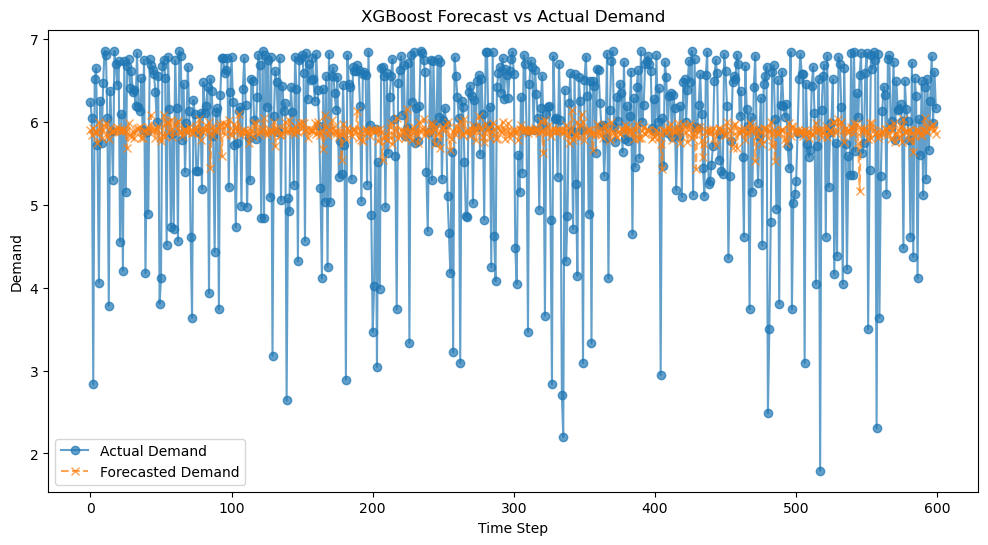

In [2]:

# 5. Demand Forecasting using RandomForest
X_demand = data_normalized[['Margin','Cost_Price', 'Price', 'Demand_Level', 'Initial_Stock', 'Current_Stock']]
y_demand = data_normalized['Historical_Sales']

# Step 3: Train-Test Split
X_demand_train, X_demand_test, y_demand_train, y_demand_test = train_test_split(X_demand, y_demand, test_size=0.2, random_state=42)

# Step 4: Define hyperparameter grid for XGBoost
param_demand_dist = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.15],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],  # Equivalent to min_samples_split
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],  # Equivalent to max_features
    'gamma': [0, 0.1]  # Regularization
}

# Step 5: Initialize XGBRegressor and RandomizedSearchCV
xgb_demand_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_demand_random = RandomizedSearchCV(
    xgb_demand_model, param_distributions=param_demand_dist, 
    n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Step 6: Fit the model
xgb_demand_random.fit(X_demand_train, y_demand_train)

# Step 7: Make predictions using the best model
best_xgb_demand_model = xgb_demand_random.best_estimator_
y_demand_pred = best_xgb_demand_model.predict(X_demand_test)

# Step 8: Evaluate the model
mae = mean_absolute_error(y_demand_test, y_demand_pred)
rmse = np.sqrt(mean_squared_error(y_demand_test, y_demand_pred))
r2 = r2_score(y_demand_test, y_demand_pred)
mape = np.mean(np.abs((y_demand_test - y_demand_pred) / y_demand_test))
accuracy = 1 - mape

print(f"XGBoost Results - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape}, Accuracy: {accuracy:.2%}")
# Step 9: Plot the Forecast vs Actual Demand
plt.figure(figsize=(12, 6))
plt.plot(y_demand_test.values, label='Actual Demand', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_demand_pred, label='Forecasted Demand', marker='x', linestyle='--', alpha=0.7)
plt.title('XGBoost Forecast vs Actual Demand')
plt.xlabel('Time Step')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [4]:
# Step 10: Compute Profitability Forecast
# Use forecasted demand and margin predictions to calculate profit
profit_pred = y_demand_pred * y_margin_pred * (X_test['Price'] - X_test['Cost_Price'])

# Actual profit 
actual_profit = y_test * y_demand_test * (X_test['Price'] - X_test['Cost_Price'])

#Denormalizing data for visualization
data_denormalized = data_normalized.copy()

def log_denormalize(x, original_col):
    return np.exp(x) + original_col.min() - 1
for col in numeric_cols:
    data_denormalized[col] = log_denormalize(data_normalized[col], data_normalized[col])
        
########################### Profitability Calculation 

# Calculate price difference (Price - Cost)
price_diff = data_denormalized['Price'] - data_denormalized['Cost_Price']

# 1. Predict profitability using margin and demand predictions
# Ensure predicted margin and demand are on the original scale
data_denormalized['Predicted_Margin'] = np.expm1(best_xgb_model.predict(X))  # Predicted Margin
data_denormalized['Predicted_Demand'] = np.expm1(best_xgb_demand_model.predict(X_demand))  # Predicted Demand

# Predicted Profitability = Predicted Margin * Price Difference * Predicted Demand
data_denormalized['Predicted_Profitability'] = (
    data_denormalized['Predicted_Margin'] * price_diff * data_denormalized['Predicted_Demand']
)
# data_denormalized['Actual_Profitability'] = (
#     data_denormalized['Historical_Sales'] * price_diff * data_denormalized['Margin']
# )
#data_denormalized[['Predicted_Profitability','Actual_Profitability']]

Profitability Forecast Results - MAE: 0.0923, RMSE: 0.1444, R²: 0.9129, Accuracy: 84.90%


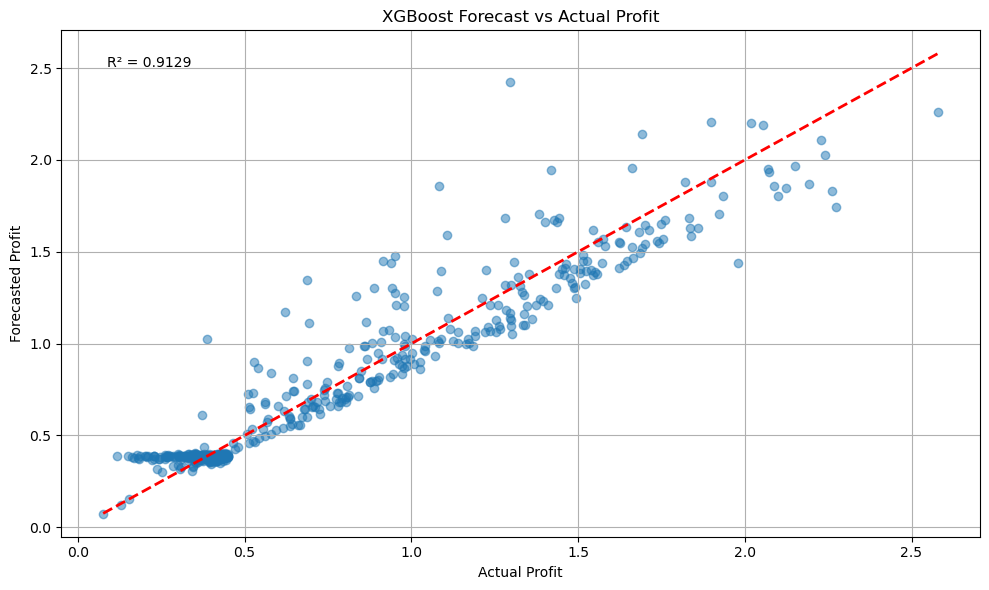

In [5]:
# Step 11: Evaluate Profitability Forecast
mae_profit = mean_absolute_error(actual_profit, profit_pred)
rmse_profit = np.sqrt(mean_squared_error(actual_profit, profit_pred))
r2_profit = r2_score(actual_profit, profit_pred)
mape_profit = np.mean(np.abs((actual_profit - profit_pred) / actual_profit))
profit_accuracy = 1 - mape_profit

print(f"Profitability Forecast Results - MAE: {mae_profit:.4f}, RMSE: {rmse_profit:.4f}, "
      f"R²: {r2_profit:.4f}, Accuracy: {profit_accuracy:.2%}")

# Step 12: Create a scatter plot of Forecast vs Actual Profit
plt.figure(figsize=(10, 6))
plt.scatter(actual_profit, profit_pred, alpha=0.5)
plt.plot([actual_profit.min(), actual_profit.max()], [actual_profit.min(), actual_profit.max()], 'r--', lw=2)
plt.title('XGBoost Forecast vs Actual Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Forecasted Profit')
plt.grid(True)

# Add text for R-squared value
plt.text(0.05, 0.95, f'R² = {r2_profit:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()

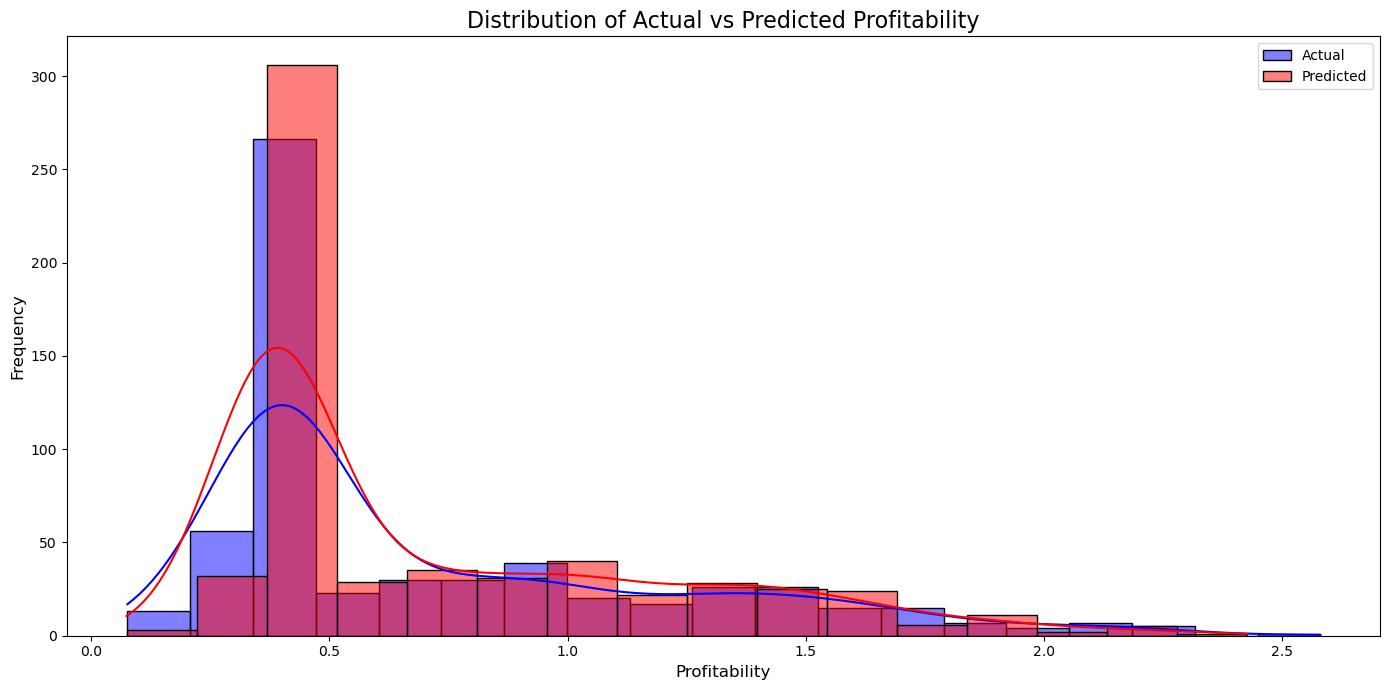

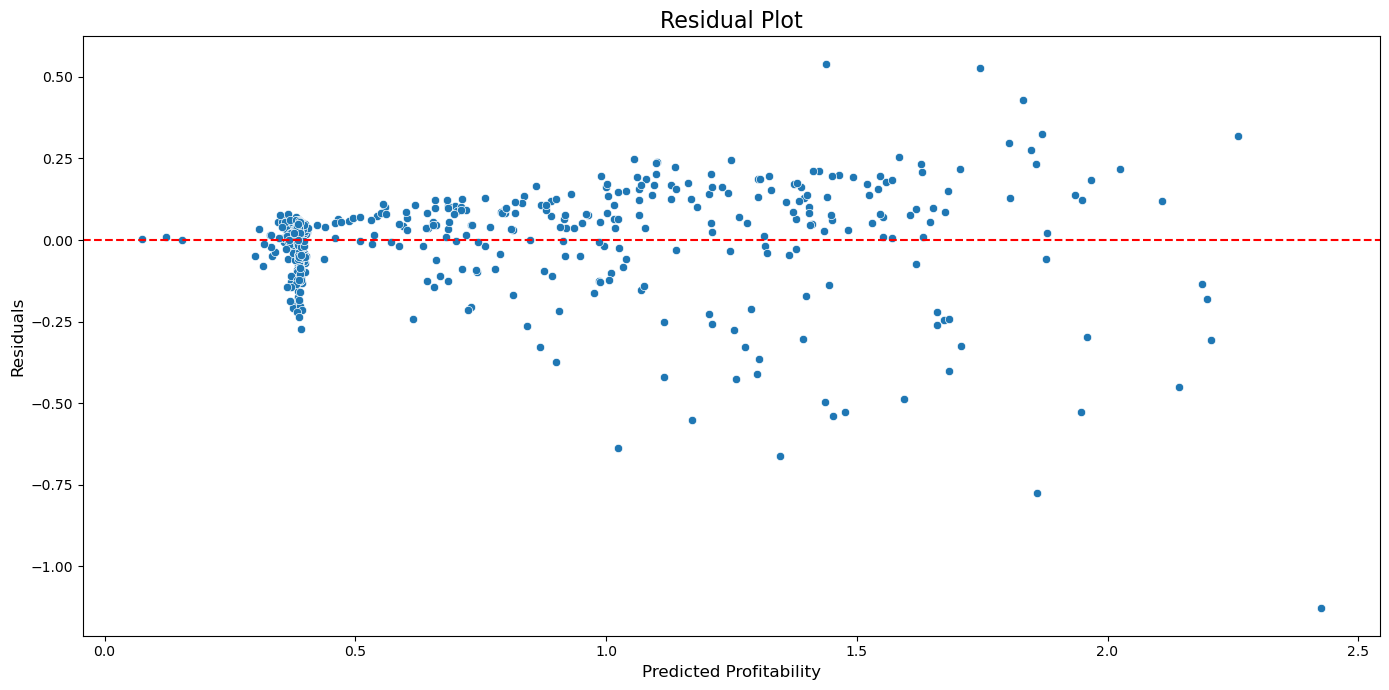

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# 5. Profitability Distribution Plot
plt.figure(figsize=(14, 7))
sns.histplot(actual_profit, kde=True, label='Actual', color='blue', alpha=0.5)
sns.histplot(profit_pred, kde=True, label='Predicted', color='red', alpha=0.5)
plt.title('Distribution of Actual vs Predicted Profitability', fontsize=16)
plt.xlabel('Profitability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# 7. Residual Plot
residuals = actual_profit - profit_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=profit_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Profitability', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.tight_layout()
plt.show()



Profit by Season:
 Season
Fall      26986479.0
Spring     9585868.0
Summer     9645504.0
Winter    30360296.0
Name: Predicted_Profitability, dtype: float64

Profit by Category:
 Category
Electronics       47506159.0
Home & Kitchen    10969656.0
Sports            10168362.0
Clothing           5790228.0
Books              2143740.0
Name: Predicted_Profitability, dtype: float64

Profit by Promotion (0 = No, 1 = Yes):
 Promotion
0    39267034.0
1    37311112.0
Name: Predicted_Profitability, dtype: float64


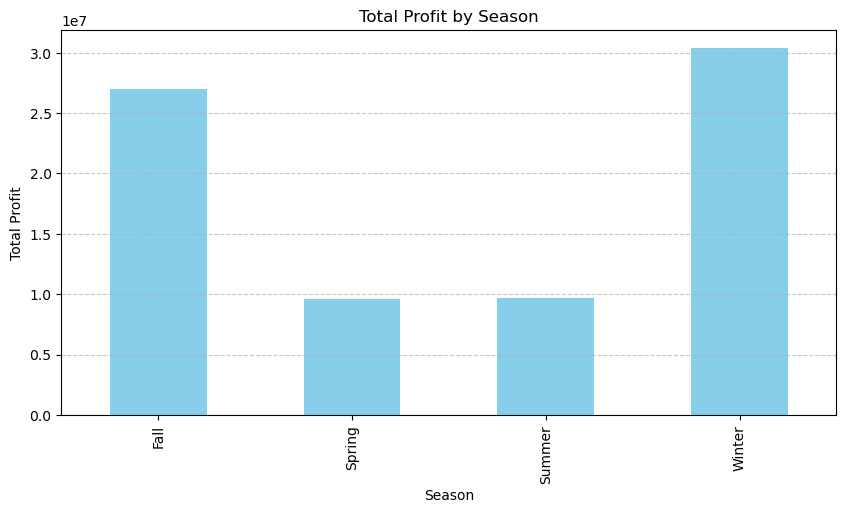

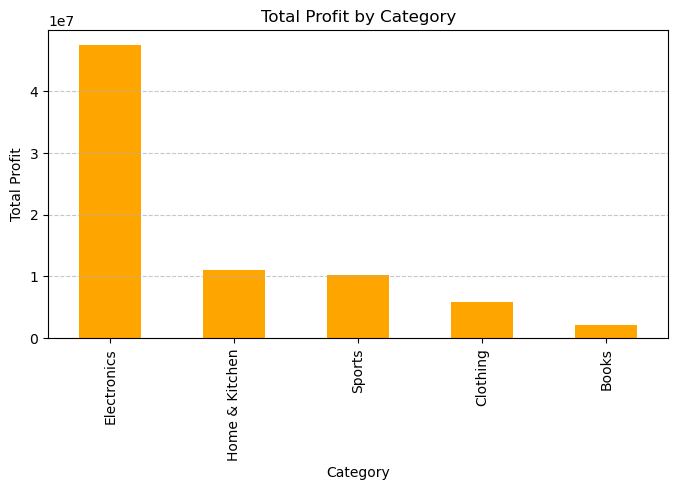

In [7]:
# 2. Seasonality Analysis: Group by Season
season_profit = round(data_denormalized.groupby('Season')['Predicted_Profitability'].sum().sort_index())
print("\nProfit by Season:\n", season_profit)
# 3. Category-Wise Profitability Analysis
category_profit = round(data_denormalized.groupby('Category')['Predicted_Profitability'].sum().sort_values(ascending=False))
print("\nProfit by Category:\n", category_profit)

# 4. Promotion Impact Analysis
promotion_profit = round(data_denormalized.groupby('Promotion')['Predicted_Profitability'].sum())
print("\nProfit by Promotion (0 = No, 1 = Yes):\n", promotion_profit)

# Visualization: Profit by Season
plt.figure(figsize=(10, 5))
season_profit.plot(kind='bar', color='skyblue')
plt.title('Total Profit by Season')
plt.xlabel('Season')
plt.ylabel('Total Profit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization: Profit by Category
plt.figure(figsize=(8, 4))
category_profit.plot(kind='bar', color='orange')
plt.title('Total Profit by Category')
plt.xlabel('Category')
plt.ylabel('Total Profit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization: Profit by Promotion
# plt.figure(figsize=(8, 4))
# promotion_profit.plot(kind='bar', color=['gray', 'green'])
# plt.title('Total Profit by Promotion')
# plt.xlabel('Promotion')
# plt.ylabel('Total Profit')
# plt.xticks([0, 1], ['No Promotion', 'With Promotion'], rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()



Profit by Season and Category:
 Category     Books   Clothing  Electronics  Home & Kitchen     Sports
Season                                                               
Fall      750053.0  1926176.0   16232788.0       4279708.0  3797754.0
Spring    238764.0   938150.0    5906857.0       1195330.0  1306766.0
Summer    242196.0   771905.0    6141258.0       1297914.0  1192231.0
Winter    912727.0  2153996.0   19225257.0       4196704.0  3871612.0


<Figure size 1400x800 with 0 Axes>

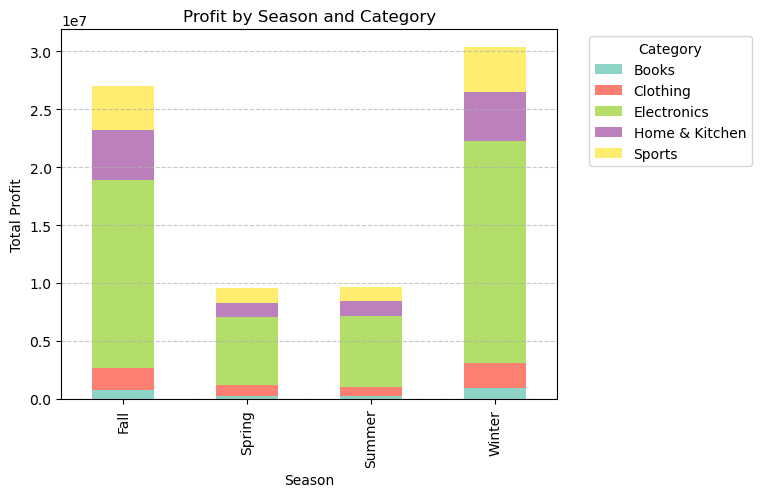


Average Profit per Unit by Category:
 Category
Electronics       395.642395
Home & Kitchen    102.718584
Sports             73.500000
Clothing           73.130137
Books              23.479608
Name: Profit_Per_Unit, dtype: float64


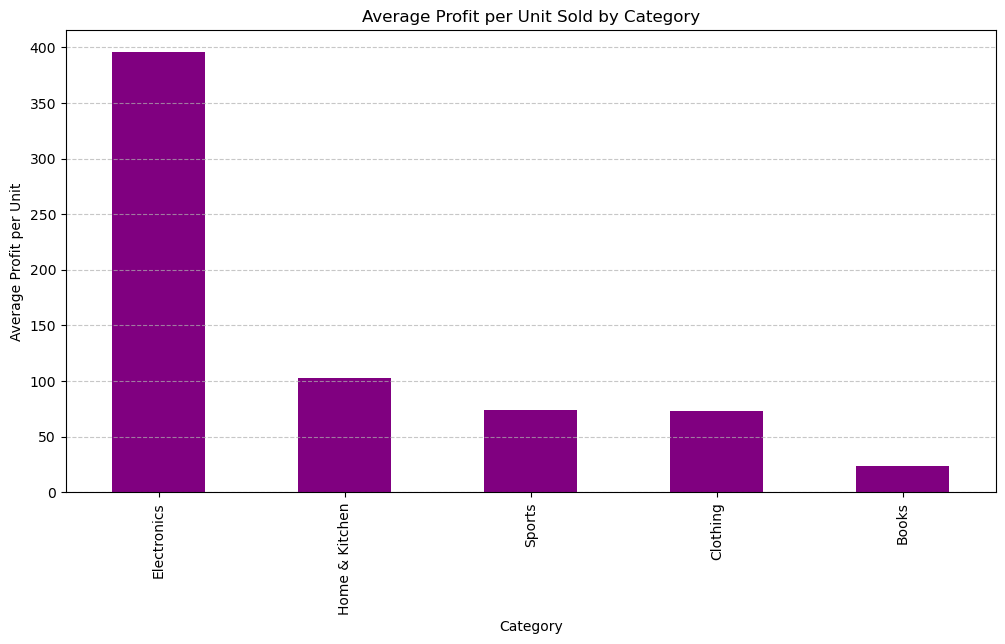


Correlation between Inventory Difference and Profit: 0.0000


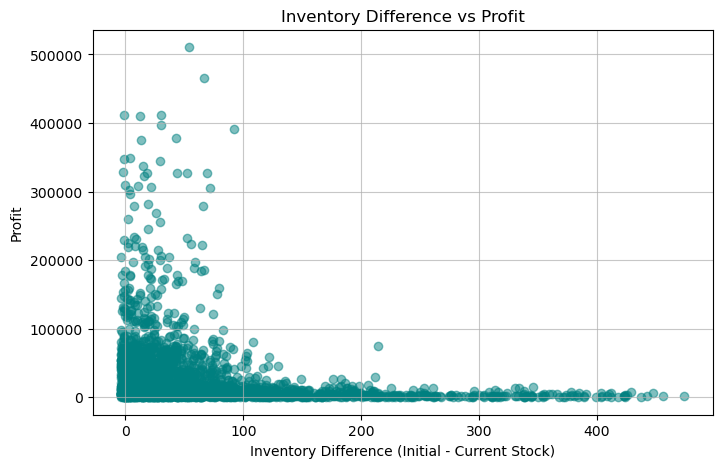

In [8]:
# 1. Season and Category Interaction Analysis
season_category_profit = round(data_denormalized.groupby(['Season', 'Category'])['Predicted_Profitability'].sum().unstack().fillna(0))
print("\nProfit by Season and Category:\n", season_category_profit)

# Visualization: Profit by Season and Category
plt.figure(figsize=(14, 8))
season_category_profit.plot(kind='bar', stacked=True, colormap='Set3')
plt.title('Profit by Season and Category')
plt.xlabel('Season')
plt.ylabel('Total Profit')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Average Profit per Unit Sold
data_denormalized['Profit_Per_Unit'] = round(data_denormalized['Predicted_Profitability'] / data_denormalized['Historical_Sales'].replace(0, np.nan))  # Handle zero sales
avg_profit_per_unit = data_denormalized.groupby('Category')['Profit_Per_Unit'].mean().sort_values(ascending=False)
print("\nAverage Profit per Unit by Category:\n", avg_profit_per_unit)

# Visualization: Average Profit per Unit by Category
plt.figure(figsize=(12, 6))
avg_profit_per_unit.plot(kind='bar', color='purple')
plt.title('Average Profit per Unit Sold by Category')
plt.xlabel('Category')
plt.ylabel('Average Profit per Unit')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Inventory Impact on Profitability
data_denormalized['Inventory_Difference'] = data_denormalized['Initial_Stock'] - data_denormalized['Current_Stock']
inventory_profit_corr =round( data_denormalized[['Inventory_Difference', 'Predicted_Profitability']].corr().iloc[0, 1])
print(f"\nCorrelation between Inventory Difference and Profit: {inventory_profit_corr:.4f}")

# Scatter Plot: Inventory Difference vs Profit
plt.figure(figsize=(8, 5))
plt.scatter(data_denormalized['Inventory_Difference'], data_denormalized['Predicted_Profitability'], alpha=0.5, color='teal')
plt.title('Inventory Difference vs Profit')
plt.xlabel('Inventory Difference (Initial - Current Stock)')
plt.ylabel('Profit')
plt.grid(alpha=0.7)
plt.show()




Top 3 Categories per Season:
     Season        Category  Predicted_Profitability
0     Fall     Electronics             1.623279e+07
1     Fall  Home & Kitchen             4.279708e+06
2     Fall          Sports             3.797754e+06
3   Spring     Electronics             5.906857e+06
4   Spring          Sports             1.306766e+06
5   Spring  Home & Kitchen             1.195330e+06
6   Summer     Electronics             6.141258e+06
7   Summer  Home & Kitchen             1.297914e+06
8   Summer          Sports             1.192231e+06
9   Winter     Electronics             1.922526e+07
10  Winter  Home & Kitchen             4.196704e+06
11  Winter          Sports             3.871612e+06


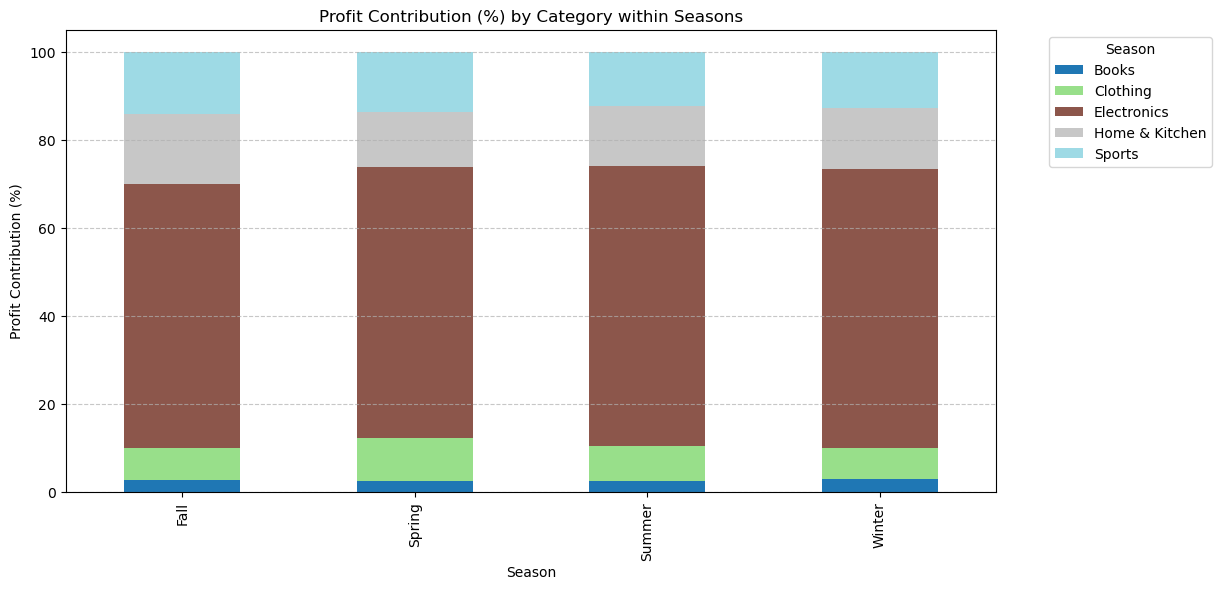


Category Profit Variance Across Seasons:
 Season
Winter    5.583387e+13
Fall      3.871524e+13
Summer    5.717098e+12
Spring    5.146693e+12
dtype: float64


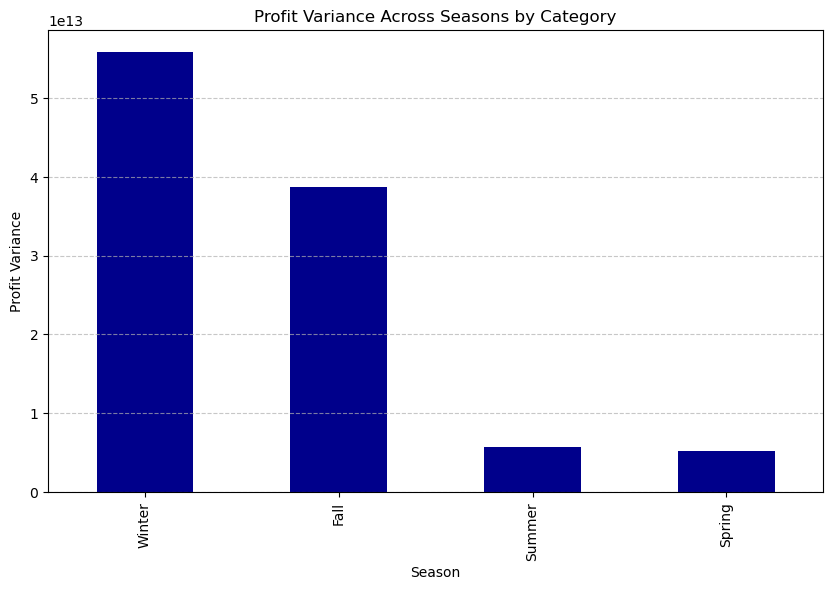

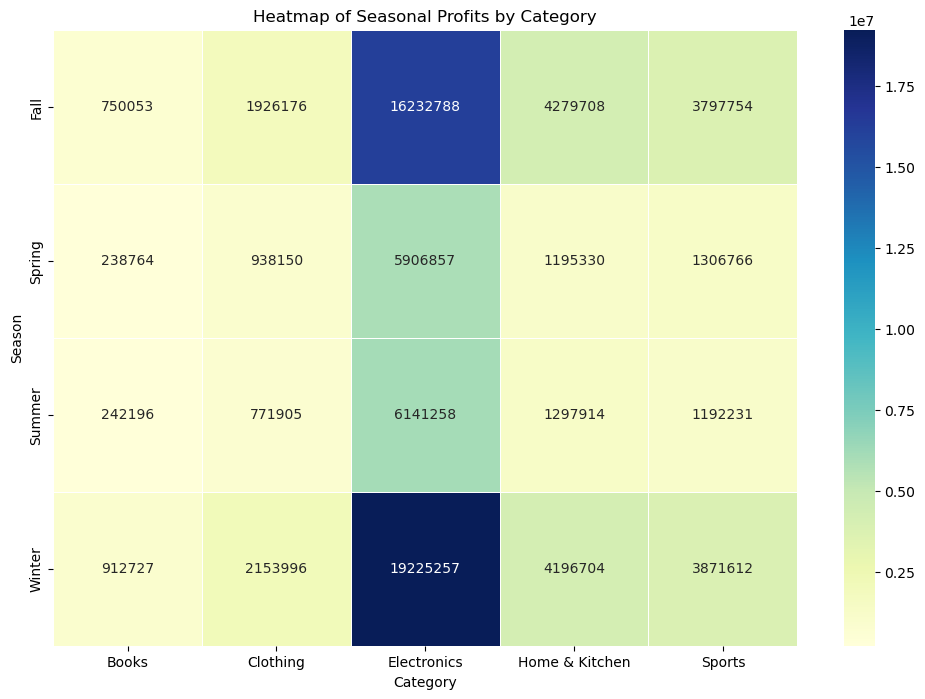

In [9]:
# 1. Top Performing Categories per Season
top_categories_season = (
    data_denormalized.groupby(['Season', 'Category'])['Predicted_Profitability']
    .sum()
    .groupby(level=0, group_keys=False)
    .nlargest(3)  # Top 3 categories per season
    .reset_index()
)
print("\nTop 3 Categories per Season:\n", top_categories_season)

# 2. Profit Contribution by Category within Each Season
season_profit = data_denormalized.groupby('Season')['Predicted_Profitability'].sum()
category_season_profit = data_denormalized.groupby(['Season', 'Category'])['Predicted_Profitability'].sum()
profit_contribution = (category_season_profit / season_profit).unstack().fillna(0) * 100

# Visualization: Profit Contribution by Category (Stacked Bar Chart)
profit_contribution.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Profit Contribution (%) by Category within Seasons')
plt.xlabel('Season')
plt.ylabel('Profit Contribution (%)')
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Category Profit Variance Across Seasons
category_profit_variance = category_season_profit.unstack().var(axis=1).sort_values(ascending=False)
print("\nCategory Profit Variance Across Seasons:\n", category_profit_variance)

# Visualization: Category Profit Variance
plt.figure(figsize=(10, 6))
category_profit_variance.plot(kind='bar', color='darkblue')
plt.title('Profit Variance Across Seasons by Category')
plt.xlabel('Season')
plt.ylabel('Profit Variance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Heatmap of Seasonal Profits by Category
import seaborn as sns

# Prepare data for heatmap
heatmap_data = category_season_profit.unstack().fillna(0)

# Visualization: Heatmap of Profits
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.0f', linewidths=0.5)
plt.title('Heatmap of Seasonal Profits by Category')
plt.xlabel('Category')
plt.ylabel('Season')
plt.show()


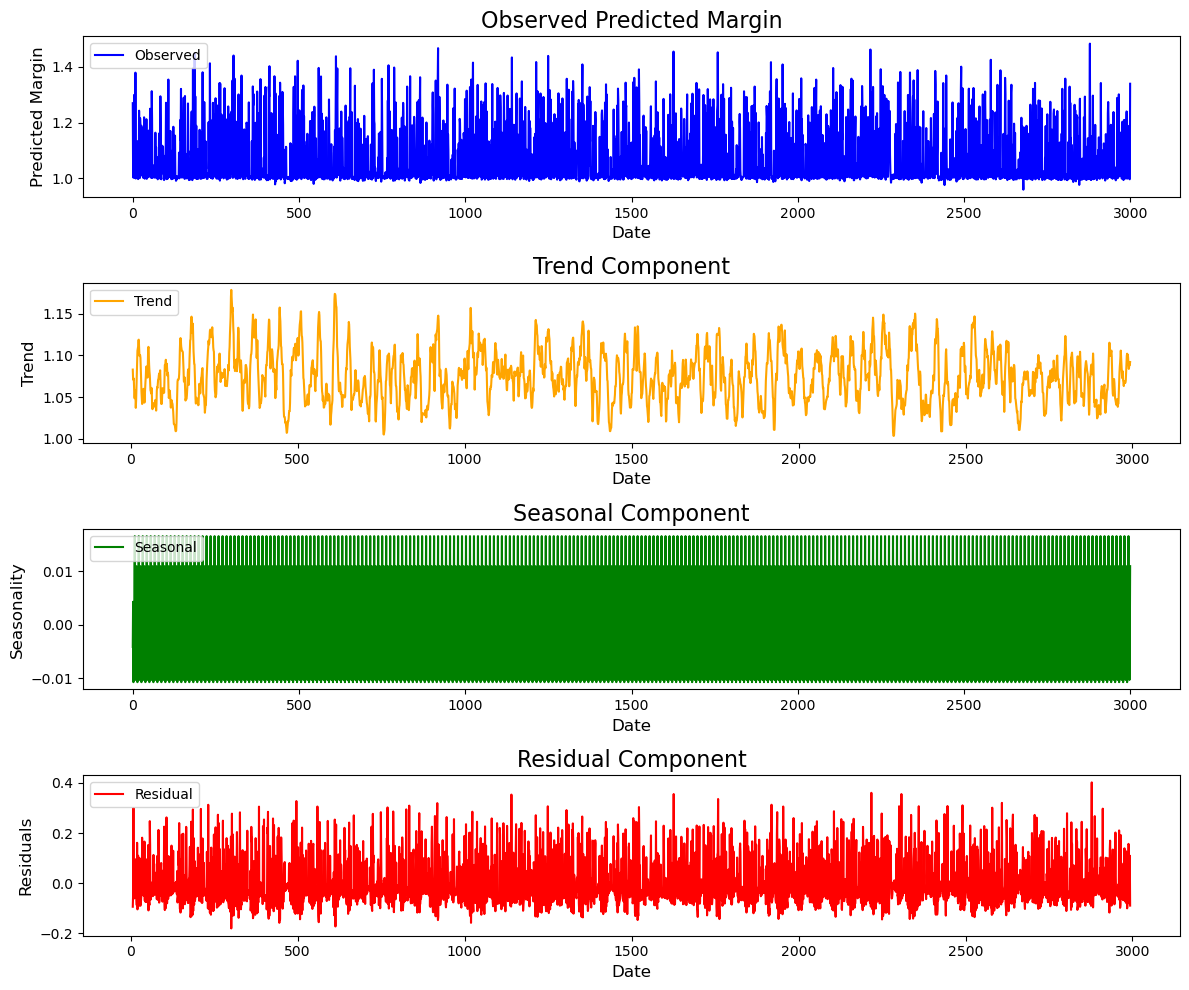

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 3: Decompose the 'Predicted Margin' time series
result = seasonal_decompose(data_denormalized['Predicted_Margin'], model='additive', period=12)

# Step 4: Plot the results with better visualization
plt.figure(figsize=(12, 10))

# Original series
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', color='blue')
plt.title('Observed Predicted Margin', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Margin', fontsize=12)
plt.legend(loc='upper left')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.title('Trend Component', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trend', fontsize=12)
plt.legend(loc='upper left')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seasonality', fontsize=12)
plt.legend(loc='upper left')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual Component', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


13:20:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MITESH\AppData\Local\Temp\ipykernel_8048\3022503385.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=45, ha='right')


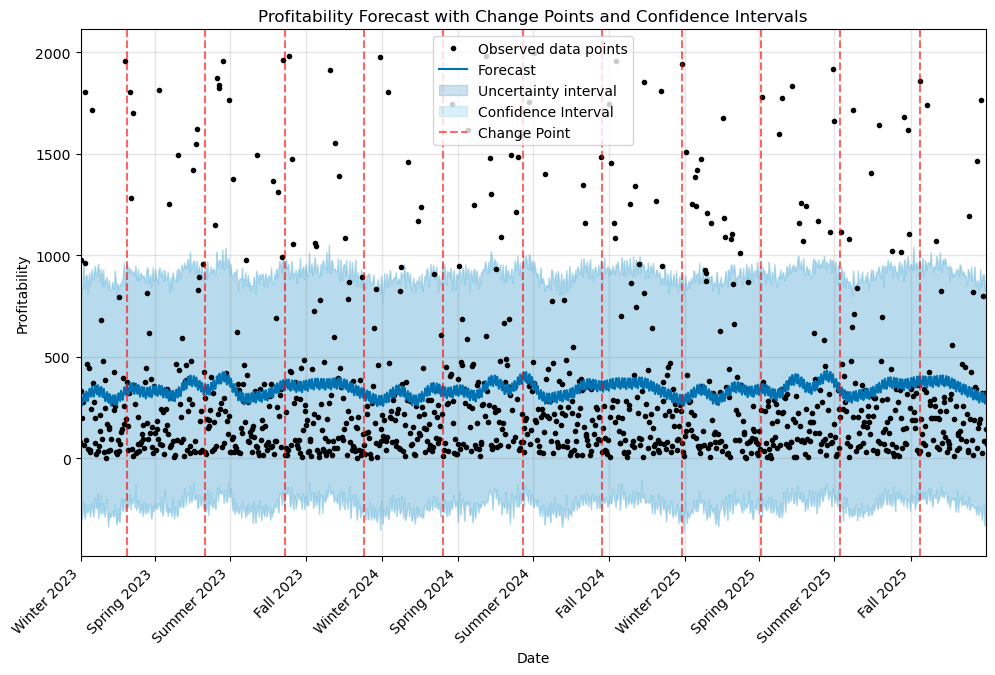

In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


# Create a synthetic date column based on seasons
seasons_per_year = 4
years = len(data_denormalized) // seasons_per_year
date_range = pd.date_range(start='2020-01-01', periods=len(data_denormalized), freq='D')

# Add the synthetic date column to the dataframe
data_denormalized['ds'] = date_range

# Calculate average Cost_Price per season
data_denormalized['y'] = data_denormalized['Cost_Price'].astype(float)  # Ensure Cost_Price is numeric
seasonal_avg = data_denormalized.groupby('ds')['y'].mean().reset_index()

# Create and fit the Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(seasonal_avg)

# Create future dates for forecasting (e.g., next 8 seasons / 2 years)
future_dates = model.make_future_dataframe(periods=8, freq='D')

# Make predictions
forecast = model.predict(future_dates)

# # Plot the forecast
# fig1 = model.plot(forecast)
# plt.title('Cost Price Forecast')
# plt.xlabel('Date')
# plt.ylabel('Average Cost Price')
# plt.show()
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Profitability Forecast with Change Points and Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Profitability')

# Highlight the confidence intervals (shaded areas between yhat_lower and yhat_upper)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3, label="Confidence Interval")

# Check if there are any change points before plotting them
change_points = model.changepoints
if not change_points.empty:
    for i, cp in enumerate(change_points):
        plt.axvline(cp, color='red', linestyle='--', alpha=0.6, label='Change Point' if i == 0 else "")

# Set the x-axis limit to the desired timeframe
plt.xlim([pd.to_datetime('2023-01-01'), pd.to_datetime('2025-12-31')])

# Customize x-axis labels for seasonality and readability
import matplotlib.dates as mdates
ax = fig1.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Ticks at seasonal starts (Jan, Apr, Jul, Oct)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')

# Define custom season labels
season_labels = {
    1: "Winter",
    4: "Spring",
    7: "Summer",
    10: "Fall"
}

# Update x-ticks with season labels
ticks = ax.get_xticks()
tick_labels = [f"{season_labels.get(d.month, '')} {d.year}" for d in mdates.num2date(ticks)]
ax.set_xticklabels(tick_labels, rotation=45, ha='right')



# Display a legend
plt.legend()

# Show the plot with the highlighted elements
plt.show()


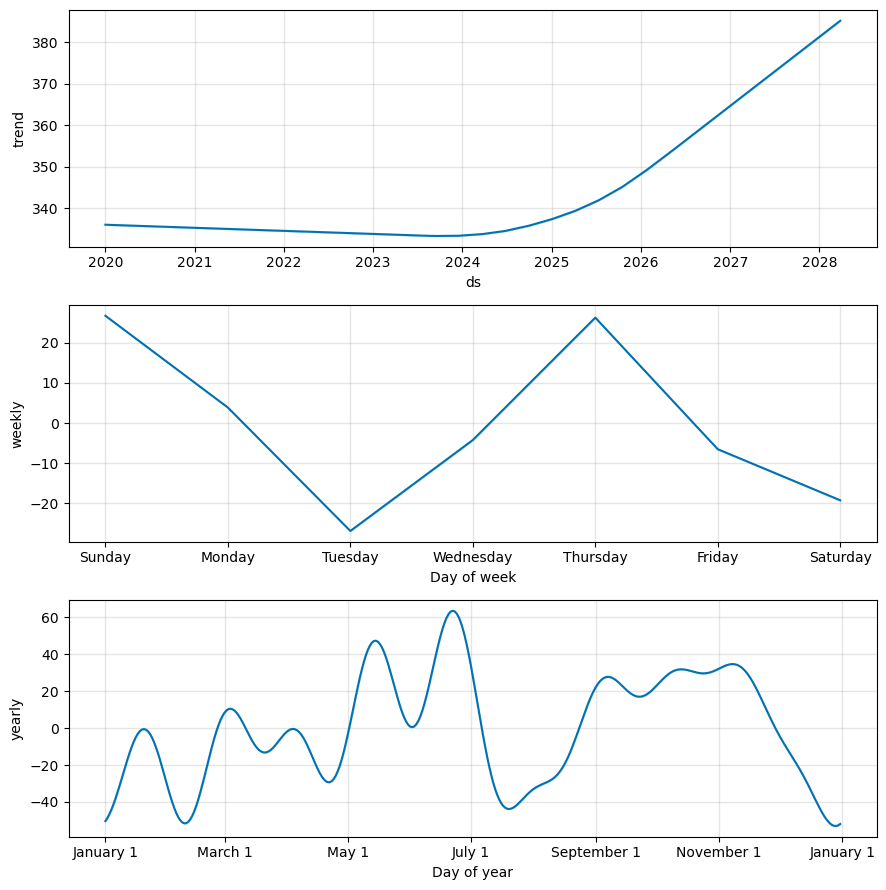

             ds        yhat  yhat_lower   yhat_upper
3000 2028-03-19  398.870938 -171.115105   991.838703
3001 2028-03-20  375.659660 -208.593501   926.177072
3002 2028-03-21  344.896484 -201.164259   927.387649
3003 2028-03-22  367.864958 -200.868402   947.047723
3004 2028-03-23  398.984793 -156.144048   979.746138
3005 2028-03-24  367.098156 -233.771026   915.087529
3006 2028-03-25  355.491482 -259.721595   949.486399
3007 2028-03-26  402.747783 -172.699998  1006.270945


In [13]:

# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

# Display the forecast for the next 8 seasons
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8))